In [0]:
#@title 小波神经网络 { display-mode: "both" }
# 程序实现包含一个小波隐藏层的小波神经网络,小波函数为 morlet 函数
# 单个隐层的小波神经网络的能力与双隐层的普通神经网络相当
# 详见 NN.py 和 NN.ipynb
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
from numpy.linalg import norm
import numpy as np 
import time

In [0]:
# 计时装饰器
def timer(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        func(*args, **kwargs)
        end_time = time.time()
        print('Training time is :{:.2f} s.'.format(end_time - start_time))
    return wrapper

## 定义网络结构类

In [0]:
class WaveletNeuralNet(object):
    # 初始化神经网络，sizes是神经网络的层数和每层神经元个数  
    def __init__(self, sizes):
        self.sizes_ = sizes
        self.num_layers_ = len(sizes)  # 层数
        if self.num_layers_ > 3:
            print('ERROR!')
        self.num_nuerals_ = sizes[1]
        self.w_ = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]  # w_、b_初始化为正态分布随机数
        self.b_ = [np.random.randn(y, 1) for y in sizes[1:]]
        self.t_ = np.random.randint(2, 15, (self.num_nuerals_, 1))
#         self.t_ = np.random.normal(5, 2., (self.num_nuerals_, 1))
        self.s_ = 2 * np.random.randn(self.num_nuerals_, 1)
    
    # 标签转化
    def one_hot(self, x, num_classes):
        x = x.flatten().astype('uint8')
        m = x.shape[0]
        x_onehot = np.zeros((m, num_classes))
        for i in range(m):
            x_onehot[i, x[i]] = 1
        return x_onehot
        
    # Sigmoid函数，S型曲线，
    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))
    
    # Sigmoid函数的导函数
    def sigmoid_der(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))
    
    # morlet小波母函数
    def phi(self, z, t=1, s=0):
        z_ = (z - s) / t
        return np.cos(1.75 * z_) * np.exp(-z_**2 / 2.)
    
    # 小波函数导数
    def phi_der(self, z, t=1, s=0):
        z_ = (z - s) / t
        return (-1.75 * np.sin(1.75 * z_) * np.exp(-z_**2 / 2) - z_ * np.cos(1.75 * z_) * np.exp(-z_**2 / 2)) / t

    def feedforward(self, x): # 前向
        n = self.w_[0].shape[1]
        x = x.reshape(n, -1)
        x1 = self.phi(np.dot(self.w_[0], x) + self.b_[0], self.t_, self.s_)
        x2 = self.sigmoid(np.dot(self.w_[1], x1) + self.b_[1])
        return x2
    
    # 反向传播
    def backprop(self, x, y):
        b_new = [np.zeros(b.shape) for b in self.b_]
        w_new = [np.zeros(w.shape) for w in self.w_]
        t_new = self.t_
        s_new = self.s_
        activation = x
        activations = [x]  # activations代表着每层的输出
        zs = []  # zs代表着每层的输入，即前层输出与权重的和
        z = np.dot(self.w_[0], activation) + self.b_[0]
        zs.append(z)
        activation = self.phi(z, t_new, s_new)
        activations.append(activation)
        z = np.dot(self.w_[1], activation) + self.b_[1]
        zs.append(z) 
        activation = self.sigmoid(z)
        activations.append(activation)
        
        delta = self.cost_derivative(activations[-1], y) * self.sigmoid_der(zs[-1])
        b_new[-1] = delta
        w_new[-1] = np.dot(delta, activations[-2].transpose())
        
        delta_last = delta.copy()
        z = zs[-2]
        sp = self.phi_der(z, t_new, s_new)
        delta = np.dot(self.w_[-1].transpose(), delta_last) * sp
        b_new[-2] = delta
        w_new[-2] = np.dot(delta, activations[-3].transpose())
        sp_t = -.5 * t_new**-1.5 * self.phi((z-s_new) / t_new) - t_new**-2.5 * (z - s_new) * self.phi_der((z - s_new) / t_new)
        sp_s = -t_new**-1.5 * self.phi_der((z-s_new) / t_new)
        # t_new = np.dot(self.w_[-1].transpose(), delta_last)*sp_t # loss函数对小波函数缩放系数的偏导
        # s_new = np.dot(self.w_[-1].transpose(), delta_last)*sp_s # loss函数对小波函数平移系数的偏导
        
        t_new = delta * sp_t # loss函数对小波函数缩放系数的偏导
        s_new = delta * sp_s # loss函数对小波函数平移系数的偏导
        
        return (b_new, w_new, t_new, s_new)

    # 更新权值w，偏移b，缩放因子t，偏移因子s
    def update_mini_batch(self, mini_batch, lr):
        b_new = [np.zeros(b.shape) for b in self.b_]
        w_new = [np.zeros(w.shape) for w in self.w_]
        a, b = mini_batch[:, :-1], self.one_hot(mini_batch[:, -1], num_classes=10)
        n = np.float(mini_batch.shape[0])
        for i in range(int(n)):
            x, y = a[i, :].reshape(-1, 1), b[i, :].reshape(-1, 1)
            delta_b_new, delta_w_new, t_new, s_new = self.backprop(x, y)
            b_new = [nb + dnb for nb, dnb in zip(b_new, delta_b_new)]
            w_new = [nw + dnw for nw, dnw in zip(w_new, delta_w_new)]
        self.w_ = [w - lr * nw for w, nw in zip(self.w_, w_new)]
        self.b_ = [b - lr * nb for b, nb in zip(self.b_, b_new)]
        self.t_ = self.t_ - lr * t_new
        self.s_ = self.s_ - lr * s_new
    
    # training_data是训练数据(x, y), epochs是训练次数, mini_batch_size是每次训练样本数, lr是learning rate，step是展示的迭代间隔
    @timer
    def SGD(self, training_data, epochs=50, mini_batch_size=32, lr=.1, step=10):
        assert type(step) == int, 'Step must be a integer.'
    
        n = training_data[0].shape[0]
        for j in range(epochs):
            ss = np.hstack((training_data[0],training_data[1].reshape(n, -1)))
            np.random.shuffle(ss)
            mini_batches = [ss[k:k + mini_batch_size, :] for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, lr)
            accur = self.evaluate(training_data) * 100
            mse_loss = self.mse_loss(training_data)
            if (j + 1) % step == 0 or j == 0:
                print("Epoch {0}, mse_loss: {1:.4f}, accury on the training set :{2:.2f}{3}".format(j+1, mse_loss, accur, '%'))
            # print("Epoch {0}: {1} / {2}".format(j, self.evaluate(training_data), n))
    
    # 计算正确率
    def evaluate(self, data):
        x_t, x_label = data
        test_results = [(np.argmax(self.feedforward(x)), y) for (x, y) in zip(list(x_t), list(x_label))]
        acc = sum(int(x == y) for (x, y) in test_results) / x_t.shape[0]
        return acc
    
    # mse_loss的导数
    def cost_derivative(self, output_activations, y):
        return (output_activations - y)
    
    # mse_loss
    def mse_loss(self, training_data):
        x_t,x_label = training_data
        test_results = [.5 * norm(self.feedforward(x).flatten() - self.one_hot(y, num_classes=10))**2
                        for (x, y) in zip(list(x_t), list(x_label))]
        return np.array(test_results).mean()
    
    # 预测
    def predict(self, data):
        data = data.reshape(-1, self.sizes_[0])
        value = np.array([np.argmax(net.feedforward(x)) for x in data], dtype='uint8')
        return value
    
    # 保存训练模型
    def save(self):
        pass  # 把_w和_b保存到文件(pickle)  
    
    def load(self):
        pass

## 主程序区

In [0]:
mnist = input_data.read_data_sets('./MNIST_data', one_hot=False)

Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz


In [0]:
training_data = mnist.train.next_batch(5000)
testing_data = mnist.test.next_batch(1000)

In [0]:
num_classes = 10  
net = WaveletNeuralNet([784, 128, num_classes])

In [0]:
net.SGD(training_data, epochs=200, mini_batch_size=32, lr=.1, step=20)

Epoch 1, mse_loss: 0.3751, accury on the training set :45.70%
Epoch 20, mse_loss: 0.0344, accury on the training set :94.98%
Epoch 40, mse_loss: 0.0216, accury on the training set :96.56%
Epoch 60, mse_loss: 0.0170, accury on the training set :97.10%
Epoch 80, mse_loss: 0.0149, accury on the training set :97.34%
Epoch 100, mse_loss: 0.0137, accury on the training set :97.48%
Epoch 120, mse_loss: 0.0132, accury on the training set :97.56%
Epoch 140, mse_loss: 0.0128, accury on the training set :97.62%
Epoch 160, mse_loss: 0.0125, accury on the training set :97.64%
Epoch 180, mse_loss: 0.0120, accury on the training set :97.74%
Epoch 200, mse_loss: 0.0114, accury on the training set :97.82%
Training time is :1233.17 s.


In [0]:
net.t_.flatten()

array([ 5.99926281,  8.00043291, 14.00014042, 11.00000388,  5.00185879,
        9.99972007,  7.99929814, 12.00021132,  6.99949758,  5.99732625,
       11.00019853, 13.00036973,  6.99996347,  8.00026806, 13.00009105,
       11.99993161, 14.00040052, 13.00014174,  6.99833223, 13.99948404,
       12.00040052,  4.99844182, 11.99986435, 13.99940152,  5.00225786,
       14.00050301,  9.99985591, 14.00002419, 10.9998781 ,  4.00122481,
        3.99687531,  4.00203889,  7.99936737,  2.01901005,  5.00201701,
       11.99943967,  7.00045245,  7.00097883,  1.9817519 , 12.99985506,
       10.00014294, 13.99984588,  4.99850054,  7.00080543, 12.00003942,
        7.99832568,  9.00029606,  6.00278197,  3.0039764 ,  3.00007383,
        8.99972669,  4.99781343,  6.00160013,  1.99956461,  9.00033254,
        9.99960331,  1.99921387,  2.99979545, 10.00019728,  7.00136695,
        3.00444585, 12.00036321, 11.00101031,  3.99907576, 10.99946211,
        6.998048  , 14.00025796,  2.99065902, 11.00019972,  2.99

In [0]:
net.s_.flatten()

array([ 0.60296722,  1.13197084, -2.56450214,  1.07134147,  0.84124828,
       -3.04680977,  0.67574533, -0.26405752,  2.33493183, -3.19912173,
        2.6021532 ,  0.7597979 , -0.4138092 ,  5.15707013, -0.23311259,
        0.49821362, -1.92977765,  0.54596715, -3.55043623,  3.16596957,
       -0.33646269, -0.30427653,  0.8166747 , -2.11114929, -3.10693054,
        1.17935125,  0.10016062, -0.69747308,  1.34386784,  0.84546045,
        3.85063761, -0.48033932,  0.77377284,  1.71341749,  3.97261919,
       -1.49550452, -2.8973523 , -1.1139667 ,  2.37786687,  0.28873692,
        1.85976615, -2.57217447,  0.71948323,  0.01949435,  0.65421979,
        3.39249591,  0.57939385,  0.75872379,  0.55953999,  2.30626955,
        2.45697248, -0.06990645,  4.22490378, -2.38761964,  0.04229035,
        0.43552474, -0.68620536,  0.92509907,  0.59979211,  1.34490551,
        1.54743176,  0.74478331,  2.02271039,  0.95566436,  2.39917177,
        0.66685988,  0.3401534 , -3.34779425, -1.16706237,  0.58

## 验证区

In [0]:
# testing_data = mnist.test.next_batch(1000)
net.evaluate(testing_data)

0.902

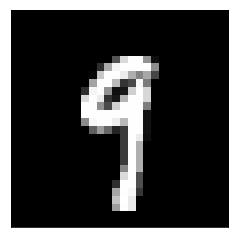

In [0]:
plt.imshow(training_data[0][10].reshape(28,-1), 'gray')
plt.xticks([]), plt.yticks([])
plt.show()

In [0]:
training_data[1][10]

9

In [0]:
net.predict(training_data[0][10])

array([9], dtype=uint8)